# Bright Star Hold 2017:068 analysis

### __Content__

1. __Star acquisition during the observation prior to entering the BSH__

1. __Attitude offset from the planned direction__

In [1]:
from Chandra.Time import DateTime
DateTime(605537911.184 ).date

'2017:069:12:57:22.000'

### __Summary__

* The BSH entry occurred at 2017:068:17:00:42 following maneauver to ObsID 50255.

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import Ska.engarchive.fetch as fetch
import Ska.quatutil as quatutil
from Ska.Matplotlib import plot_cxctime
from Chandra.Time import DateTime
from chandra_aca.plot import plot_stars
from Quaternion import Quat
from kadi import events
#from itertools import izip, count
import agasc

In [3]:
import Ska.engarchive.fetch as fetch
from Ska.Matplotlib import plot_cxctime

In [4]:
from mica.archive import aca_l0, asp_l1
import Ska.arc5gl
import os

In [5]:
keys = ['aoacmag', 'aoacyan', 'aoaczan']
slots = range(8)
msids_star = []
for slot in slots:
    msids = [key + np.str(slot) for key in keys]
    msids_star = msids_star + msids

### Star acquistion and identification ###

ObsIDs and maneuvers prior to the Bright Star Hold:
1. Maneuver to ObsID=50256.
2. Maneuver to ObsID=50255 (ended with the BSH transition).

In [6]:
# https://icxc.cfa.harvard.edu/mp/mplogs/2017/MAR0617/oflsa/starcheck.html#obsid50260

obsids = [50256, 50255]

manvrs = events.manvrs.filter(start='2017:068:16:00:00.000',
                              stop='2017:068:18:00:00.000')

rows = []
for i, manvr in enumerate(manvrs):
    row = {'no': i + 1, 'start': manvr.start, 'stop': manvr.stop,
           'one_shot': manvr.one_shot, 'dur': manvr.dur,
           'tstart': manvr.tstart, 'tstop': manvr.tstop,
           'to_obsid': obsids[i]}
    rows.append(row)

tab = Table(rows,
            names=('no', 'start', 'stop', 'one_shot',
                   'tstart', 'tstop', 'dur', 'to_obsid'),
            dtype=('i2', 'S20', 'S20', 'f4',
                   'f8', 'f8', 'f4', 'i4'))
print(tab['no', 'start', 'stop', 'dur', 'one_shot', 'to_obsid'])

 no        start                 stop           dur   one_shot to_obsid
--- -------------------- -------------------- ------- -------- --------
  1 2017:068:15:18:14.14 2017:068:16:06:13.36 2879.23  50.3714    50256
  2 2017:068:16:27:23.34 2017:068:16:59:35.46 1932.13    -99.0    50255


### OBSID=50256 ###

In [7]:
# Fetch aoacmag, aoacyan, aoaczan telemetry
start = tab['tstart'][0]
stop = tab['tstop'][1]
telem = fetch.MSIDset(msids_star, start=start, stop=stop)

In [8]:
# Define reference times for average mag, yan, zan calculations
start_av = tab['tstop'][0] + 180
stop_av = tab['tstart'][1] - 5
times = [start_av, stop_av]

White: ObsID 50256
Gray: Maneuvers


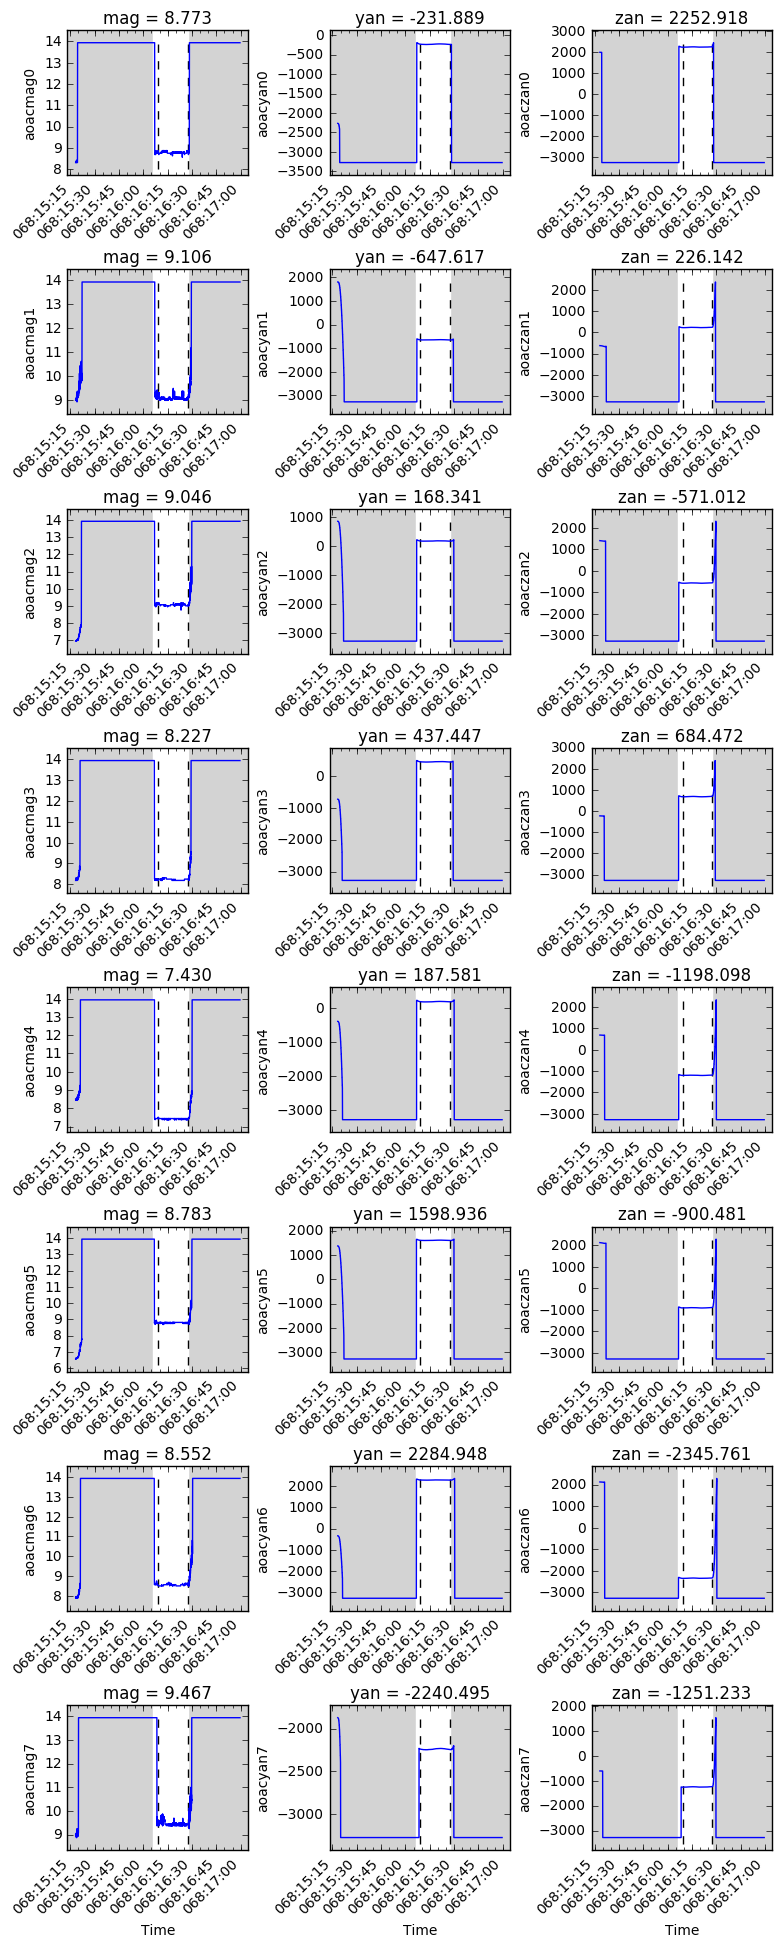

In [9]:
plt.figure(figsize=(7.5, 26))

rows = []
row = {}

for idx, msid in enumerate(msids_star):
    # Plot
    plt.subplot(8, 3, idx + 1, axisbg='lightgray')
    plot_cxctime(telem[msid].times, telem[msid].vals)
    plt.ylabel(msid)
    plt.xlabel("Time")
    plt.margins(0.05)  
    
    t1, t2 = times
    times_mean = (telem[msid].times > t1) & (telem[msid].times < t2)
    # Average mag, yan, zan
    average = telem[msid].vals[times_mean].mean()
    plt.title('{} = {:.3f}'.format(msid[4:7], average))
    
    row[msid[:-1]] = average
    
    if np.mod(idx, 3) == 2:
        rows.append(row)
        row = {}

# Mark obsid time span (white) and reference times (dashed lines)
start_50256 = DateTime(tab['tstop'][0]).plotdate
stop_50256 = DateTime(tab['tstart'][1]).plotdate

for idx, ax in enumerate(plt.gcf().axes):
    plt.setp(ax.get_xticklabels(), visible=True, rotation=45, ha='right')
    ax.axvspan(start_50256, stop_50256, ymin=-5000, ymax=5000, color='white')
    ax.vlines(DateTime(times).plotdate, ax.get_ylim()[0], ax.get_ylim()[1],
              color='k', linestyle='--')
    
plt.subplots_adjust(left=0.05, bottom=0.2, right=0.99, top=0.9, wspace=0.45, hspace=0.65)

print('White: ObsID 50256')
print('Gray: Maneuvers')

In [10]:
t_50256 = Table(rows)

In [11]:
print(t_50256['aoacyan', 'aoaczan', 'aoacmag'])

   aoacyan        aoaczan     aoacmag
-------------- -------------- -------
-231.888634216  2252.91795841 8.77333
-647.616706049  226.142178639 9.10574
 168.341280718 -571.012121928 9.04643
  437.44676276  684.471904537 8.22672
 187.580529301 -1198.09832231 7.43023
 1598.93558601 -900.480789225 8.78344
 2284.94834594 -2345.76148393 8.55246
-2240.49539225 -1251.23298677 9.46745


In [12]:
# Kadi, attitude solution:

# Attitude solution
# Coordinates
#
# RA=153.29005786
# Dec=-14.7859242657
# Roll=318.021675418
# 
# Q1=-0.198935734276
# Q2=-0.317858483705
# Q3=0.911494640823
# Q4=0.169020938689
#
#  
# Star match summary and residuals 
#
# slot      YAG            ZAG       MAG_ACA  m_yag     dy   m_zag     dz   dr  m_agasc_id
# ---- -------------- -------------- ------- -------- ----- -------- ----- ---- ----------
#   0 -231.888634216  2252.91795841 8.77333  -231.93  0.04  2253.20 -0.28 0.29  720378144
#   1 -647.616706049  226.142178639 9.10574  -647.44 -0.17   226.19 -0.04 0.18  720379064
#   2  168.341280718 -571.012121928 9.04643   168.48 -0.14  -571.25  0.23 0.27  720379688
#   3   437.44676276  684.471904537 8.22672   437.47 -0.02   684.48 -0.01 0.02  720379744
#   4  187.580529301 -1198.09832231 7.43023   187.58  0.00 -1198.13  0.03 0.03  794169304
#   5  1598.93558601 -900.480789225 8.78344  1599.17 -0.23  -900.73  0.25 0.34  794175152
#   6  2284.94834594 -2345.76148393 8.55246  2284.89  0.06 -2345.46 -0.30 0.30  794177720
#   7 -2240.49539225 -1251.23298677 9.46745 -2240.97  0.47 -1251.35  0.12 0.49  719457696

q_kadi = Quat([-0.198935734276, -0.317858483705, 0.911494640823, 0.169020938689])

# Starcheck, OBSID=50256
# MP_TARGQUAT at 2017:068:15:18:08.440 (VCDU count = 7516924)
# Q1,Q2,Q3,Q4: -0.19892659  -0.31782754  0.91150559  0.16903083

q_planned = Quat([-0.19892659, -0.31782754, 0.91150559, 0.16903083])

dq = q_kadi.dq(q_planned)

print('d(Roll) = {:.1f} arcsec'.format(dq.roll0 * 3600))
print('d(Pitch) = {:.1f} arcsec'.format(dq.pitch * 3600))
print('d(Yaw) = {:.1f} arcsec'.format(dq.yaw * 3600))

offset = agasc.agasc.sphere_dist(q_kadi.ra, q_kadi.dec, q_planned.ra, q_planned.dec)
offset = (offset * u.deg).to('arcsec').value

print('\nOffset = {:.1f} arcsec'.format(offset))
print('One_shot = {:.1f} arcsec'.format(tab['one_shot'][0]))

d(Roll) = 14.5 arcsec
d(Pitch) = -0.9 arcsec
d(Yaw) = -1.6 arcsec

Offset = 1.8 arcsec
One_shot = 50.4 arcsec


### Gyro bias ###

In [13]:
msids_gb = ['aogbias1', 'aogbias2', 'aogbias3']
axes = ['Roll', 'Pitch', 'Yaw']
colors = 'bgm'

In [14]:
start = tab['tstart'][0]
stop = tab['tstop'][1]
telem_gb = fetch.MSIDset(msids_gb, start=start, stop=stop)

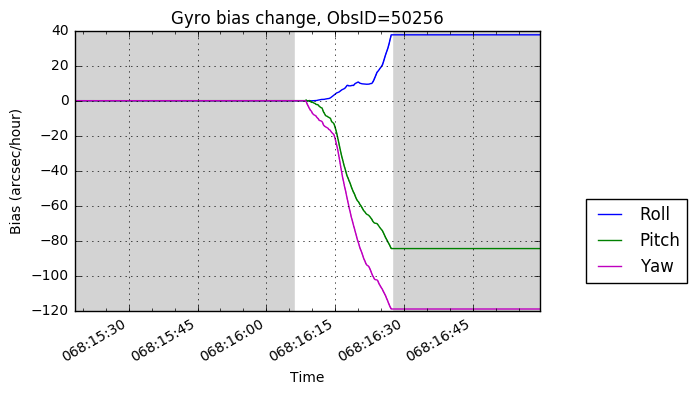

In [15]:
plt.figure()
plt.subplot(1, 1, 1, axisbg='lightgray')
colors = 'bgm'
for i, msid in enumerate(msids_gb):
    plot_cxctime(telem_gb[msid].times,
                 ((telem_gb[msid].vals - telem_gb[msid].vals[0]) * u.radian / u.s).to('arcsec/hr'),
                 color=colors[i], label=axes[i])

plt.ylabel('Bias (arcsec/hour)')
plt.xlabel('Time')
plt.title('Gyro bias change, ObsID=50256')
plt.grid()
ylim = [-20, 20]
ax = plt.gca()
ax.axvspan(start_50256, stop_50256, ymin=-5000, ymax=5000, color='white')
plt.legend(loc=(1.1, 0.1));

### OBSID=50255 ###

In [16]:
# Fetch aoacmag, aoacyan, aoaczan telemetry
start = tab['tstop'][1]
stop = '2017:068:17:05:00'
time_bsh = '2017:068:17:00:42'
telem = fetch.MSIDset(msids_star, start=start, stop=stop)

In [17]:
# Define reference times for average mag, yan, zan calculations
start_av = DateTime('2017:068:17:00:25').secs
stop_av = DateTime(time_bsh).secs
times = [start_av, stop_av]

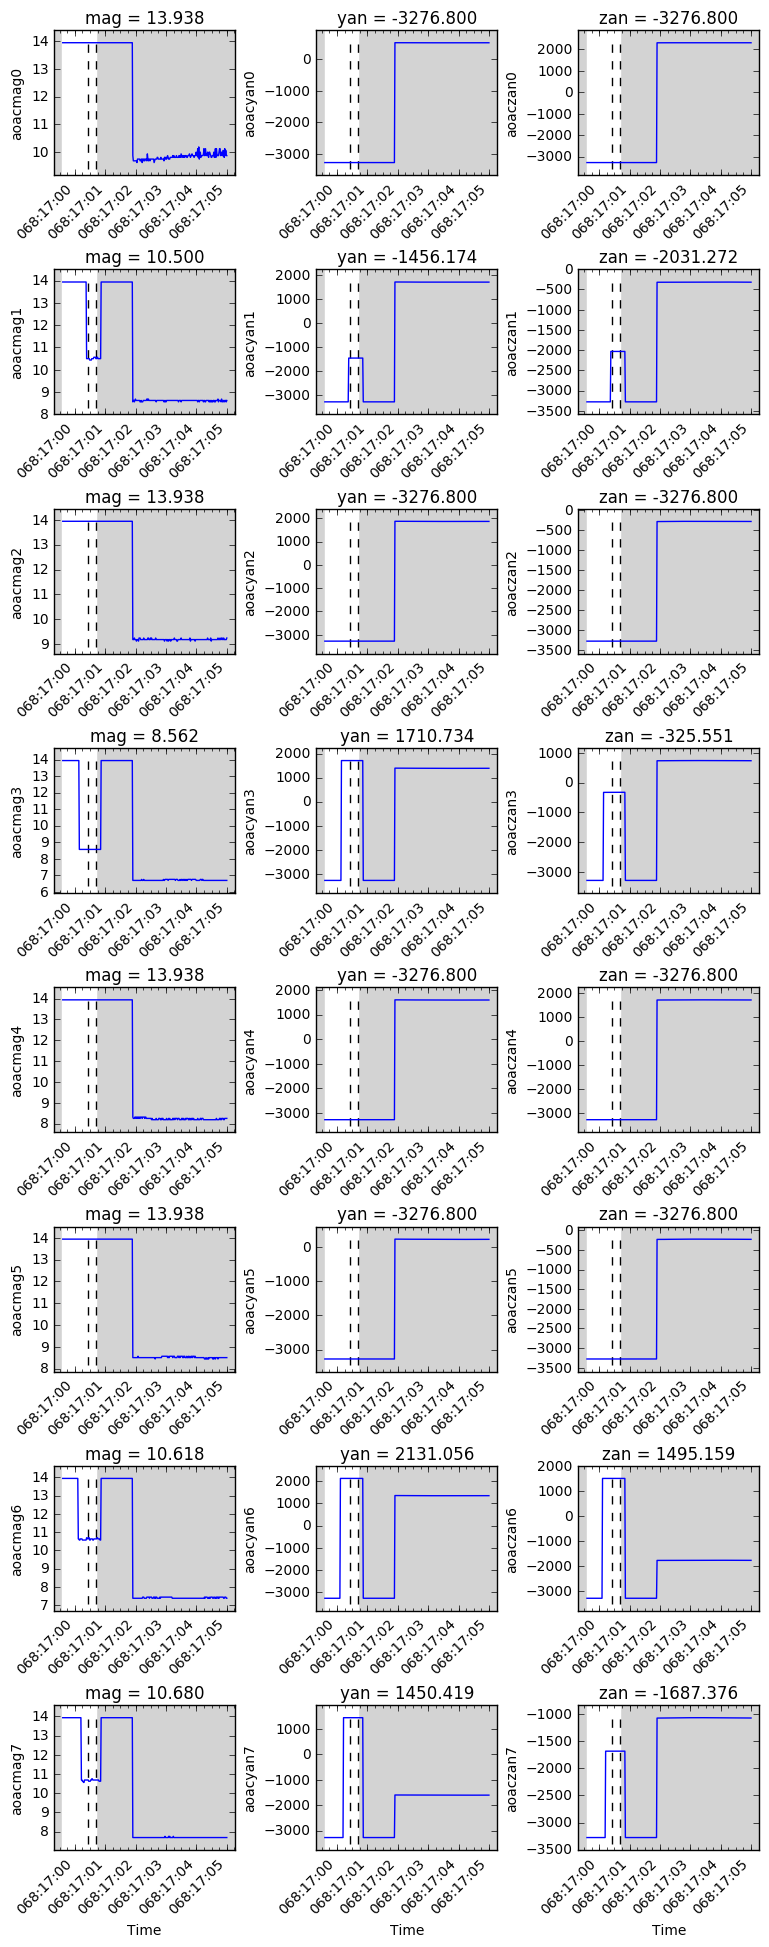

In [18]:
plt.figure(figsize=(7.5, 26))

rows = []
row = {}

for idx, msid in enumerate(msids_star):
    # Plot
    plt.subplot(8, 3, idx + 1, axisbg='lightgray')
    plot_cxctime(telem[msid].times, telem[msid].vals)
    plt.ylabel(msid)
    plt.xlabel("Time")
    plt.margins(0.05)
    
    times_av = (telem[msid].times > times[0]) & (telem[msid].times < times[1])
    # Average mag, yan, zan
    average = telem[msid].vals[times_av].mean()
    plt.title('{} = {:.3f}'.format(msid[4:7], average))
    row[msid[:-1]] = average
    
    if np.mod(idx, 3) == 2:
        rows.append(row)
        row = {}

# Mark obsid time span (white) and reference times (dashed lines)
start_50255 = DateTime(start).plotdate
stop_50255 = DateTime(time_bsh).plotdate

for idx, ax in enumerate(plt.gcf().axes):
    plt.setp(ax.get_xticklabels(), visible=True, rotation=45, ha='right')
    ax.axvspan(start_50255, stop_50255, ymin=-5000, ymax=5000, color='white')
    ax.vlines(DateTime(times).plotdate, ax.get_ylim()[0], ax.get_ylim()[1],
              color='k', linestyle='dashed')

plt.subplots_adjust(left=0.05, bottom=0.2, right=0.99, top=0.9, wspace=0.45, hspace=0.65)

In [19]:
t_50255 = Table(rows)

In [20]:
print(t_50255['aoacyan', 'aoaczan', 'aoacmag'])

   aoacyan        aoaczan     aoacmag
-------------- -------------- -------
       -3276.8        -3276.8 13.9375
-1456.17352941 -2031.27205882    10.5
       -3276.8        -3276.8 13.9375
 1710.73382353 -325.551470588  8.5625
       -3276.8        -3276.8 13.9375
       -3276.8        -3276.8 13.9375
 2131.05588235  1495.15882353 10.6176
 1450.41911765 -1687.37647059 10.6801


In [21]:
# Kadi, find_attitude
#
# ERROR
#
#    No matching solutions found.
# Try increasing distance and/or magnitude tolerance. (120 arcsec)

__Star acquisition following the BSH transition__

In [22]:
# Define reference times for average mag, yan, zan calculations
start_av = DateTime('2017:068:17:02:00').secs
stop_av = DateTime('2017:068:17:02:15').secs
times = [start_av, stop_av]

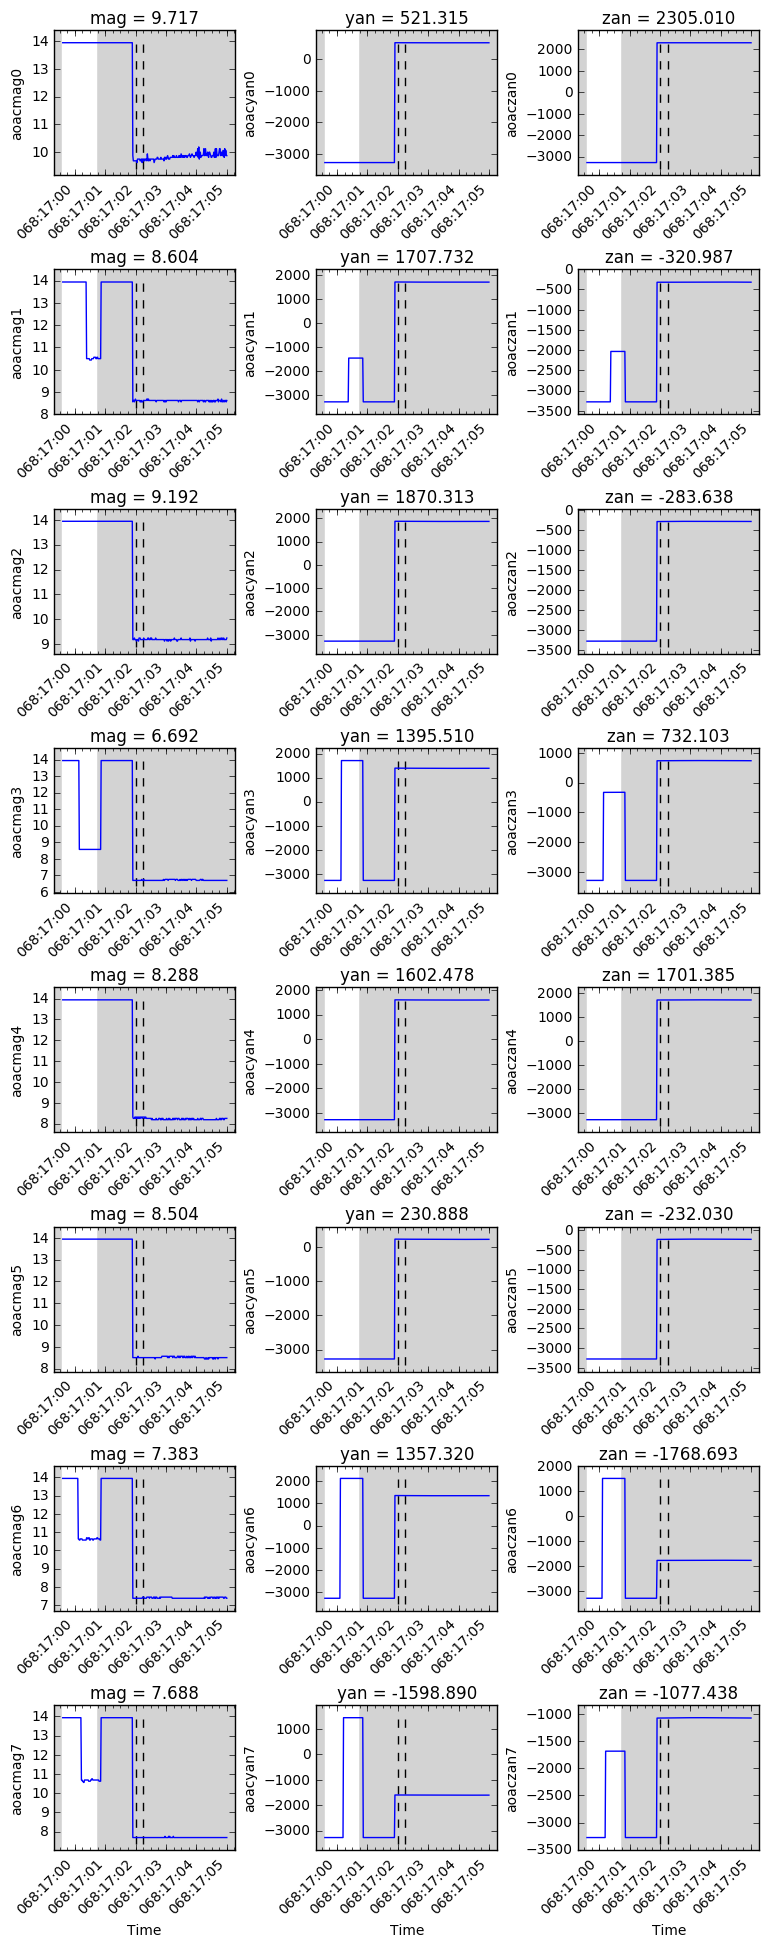

In [23]:
plt.figure(figsize=(7.5, 26))

rows = []
row = {}

for idx, msid in enumerate(msids_star):
    # Plot
    plt.subplot(8, 3, idx + 1, axisbg='lightgray')
    plot_cxctime(telem[msid].times, telem[msid].vals)
    plt.ylabel(msid)
    plt.xlabel("Time")
    plt.margins(0.05)
    
    times_av = (telem[msid].times > times[0]) & (telem[msid].times < times[1])
    # Average mag, yan, zan
    average = telem[msid].vals[times_av].mean()
    plt.title('{} = {:.3f}'.format(msid[4:7], average))
    row[msid[:-1]] = average
    
    if np.mod(idx, 3) == 2:
        rows.append(row)
        row = {}

# Mark obsid time span (white) and reference times (dashed lines)
start_50255 = DateTime(start).plotdate
stop_50255 = DateTime(time_bsh).plotdate

for idx, ax in enumerate(plt.gcf().axes):
    plt.setp(ax.get_xticklabels(), visible=True, rotation=45, ha='right')
    ax.axvspan(start_50255, stop_50255, ymin=-5000, ymax=5000, color='white')
    ax.vlines(DateTime(times).plotdate, ax.get_ylim()[0], ax.get_ylim()[1],
              color='k', linestyle='dashed')

plt.subplots_adjust(left=0.05, bottom=0.2, right=0.99, top=0.9, wspace=0.45, hspace=0.65)

In [24]:
t_bsh = Table(rows)

In [25]:
print(t_bsh['aoacyan', 'aoaczan', 'aoacmag'])

   aoacyan       aoaczan     aoacmag
------------- -------------- -------
      521.315        2305.01 9.71667
1707.73166667 -320.986666667 8.60417
1870.31333333 -283.638333333 9.19167
      1395.51  732.103333333 6.69167
1602.47833333       1701.385  8.2875
230.888333333        -232.03 8.50417
      1357.32 -1768.69333333 7.38333
     -1598.89 -1077.43833333  7.6875


In [26]:
# Kadi, find_attitude
#
# Attitude solution
# Coordinates
#
# RA=41.3600215459
# Dec=-42.4017083826
# Roll=244.926678918
#
# Q1=-0.80449576228
# Q2=-0.0961912973433
# Q3=0.462193368926
# Q4=0.360431813953
#
#  
# Star match summary and residuals 
#
# slot      YAG           ZAG       MAG_ACA  m_yag     dy   m_zag     dz   dr  m_agasc_id
# ---- ------------- -------------- ------- -------- ----- -------- ----- ---- ----------
#   0       521.315        2305.01 9.71667       --    --       --    --   --         --
#   1 1707.73166667 -320.986666667 8.60417  1707.72  0.01  -320.53 -0.46 0.46  991560432
#   2 1870.31333333 -283.638333333 9.19167  1869.38  0.93  -284.85  1.21 1.52  991559968
#   3       1395.51  732.103333333 6.69167  1395.55 -0.04   732.44 -0.33 0.34  991561008
#   4 1602.47833333       1701.385  8.2875  1602.71 -0.24  1701.69 -0.30 0.38  991564904
#   5 230.888333333        -232.03 8.50417   231.40 -0.51  -231.93 -0.10 0.52  991175320
#   6       1357.32 -1768.69333333 7.38333  1357.55 -0.23 -1768.42 -0.27 0.35  991560472
#   7      -1598.89 -1077.43833333  7.6875 -1598.97  0.08 -1077.69  0.25 0.26  991169936

q_kadi = Quat([-0.80449576228, -0.0961912973433, 0.462193368926, 0.360431813953])

# OBSID = 50255
# MP_TARGQUAT at 2017:068:16:27:17.180 (VCDU count = 7533114)
# Q1,Q2,Q3,Q4: -0.80436588  -0.09580606  0.46243239  0.36051771

q_planned = Quat([-0.80436588, -0.09580606, 0.46243239, 0.36051771])

dq = q_kadi.dq(q_planned)

print('d(Roll) = {:.1f} arcsec'.format(dq.roll0 * 3600))
print('d(Pitch) = {:.1f} arcsec'.format(dq.pitch * 3600))
print('d(Yaw) = {:.1f} arcsec'.format(dq.yaw * 3600))

offset = agasc.agasc.sphere_dist(q_kadi.ra, q_kadi.dec, q_planned.ra, q_planned.dec)
offset = (offset * u.deg).to('arcsec').value

print('\nOffset = {:.1f} arcsec'.format(offset))

d(Roll) = 130.7 arcsec
d(Pitch) = -43.4 arcsec
d(Yaw) = 141.8 arcsec

Offset = 148.4 arcsec
